#  **Diabetic Retinopathy Detection 10,000 Images**

In this notebook, we work with a dataset of approximately 10,000 images. The dataset was created keeping the proportions of the kaggle challenge train set.

# **1. Imports**

In [ ]:
import os
import pandas as pd
import numpy as np
import glob
import cv2
import torch
import random
import shutil
import matplotlib.pyplot as plt
import torch.nn.functional as F
import tensorflow as tf
import torch.optim as optim
import seaborn as sns
import torchvision.models as models
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from PIL import Image
from skimage.io import imread
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from tensorflow.image import resize
from sklearn.metrics import confusion_matrix, accuracy_score
from concurrent.futures import ThreadPoolExecutor
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# **2. Loading Data and EDA**

We create a dataframe containing:
- the image name;
- the path to the image;
- a variable specifying if the eye is the right one (0) or the left one (1);
- the label specifying the level of the retinopathy desease (0 to 4);
- the patient ID.

In [ ]:
base_image_dir = os.path.join('..', '/content/drive/.shortcut-targets-by-id/1d7g7M2sbwEkMN6EMiOt6tY_ffsSNCtg1/DATA_UNZIPPED/DATA_10K')
retina_df = pd.read_csv(os.path.join('/content/drive/.shortcut-targets-by-id/1d7g7M2sbwEkMN6EMiOt6tY_ffsSNCtg1/DATA_UNZIPPED/', 'trainLabels.csv'))

retina_df['PatientId'] = retina_df['image'].map(lambda x: x.split('_')[0])
retina_df['path'] = retina_df['image'].map(lambda x: os.path.join(base_image_dir, '{}.jpeg'.format(x)))

retina_df['exists'] = retina_df['path'].map(os.path.exists)
print(retina_df['exists'].sum(), 'images found of', retina_df.shape[0], 'total')
retina_df['eye'] = retina_df['image'].map(lambda x: 1 if x.split('_')[-1]=='left' else 0)

retina_df = retina_df[retina_df['exists']]
retina_df

10001 images found of 35126 total


,image,level,PatientId,path,exists,eye
0,10_left,0,10,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,1
2,13_left,0,13,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,1
3,13_right,0,13,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,0
4,15_left,1,15,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,1
6,16_left,4,16,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,1
...,...,...,...,...,...,...
35108,44331_left,0,44331,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,1
35112,44337_left,1,44337,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,1
35115,44338_right,0,44338,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,0
35119,44343_right,0,44343,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,0


In [ ]:
print(retina_df['exists'].sum(), 'images found of', retina_df.shape[0], 'total')

def one_hot_encode(category, max_value):
    one_hot = [0] * (max_value + 1)
    one_hot[category] = 1
    return one_hot

max_level = retina_df['level'].max()
retina_df = retina_df[retina_df['exists']]

10001 images found of 10001 total


<ipython-input-4-aeba3a43bc82>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retina_df['level_cat'] = retina_df['level'].apply(lambda x: one_hot_encode(x, max_level))


In [ ]:
retina_df

,image,level,PatientId,path,exists,eye,level_cat
0,10_left,0,10,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,1,"[1, 0, 0, 0, 0]"
2,13_left,0,13,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,1,"[1, 0, 0, 0, 0]"
3,13_right,0,13,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,0,"[1, 0, 0, 0, 0]"
4,15_left,1,15,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,1,"[0, 1, 0, 0, 0]"
6,16_left,4,16,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,1,"[0, 0, 0, 0, 1]"
...,...,...,...,...,...,...,...
35108,44331_left,0,44331,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,1,"[1, 0, 0, 0, 0]"
35112,44337_left,1,44337,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,1,"[0, 1, 0, 0, 0]"
35115,44338_right,0,44338,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,0,"[1, 0, 0, 0, 0]"
35119,44343_right,0,44343,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,0,"[1, 0, 0, 0, 0]"


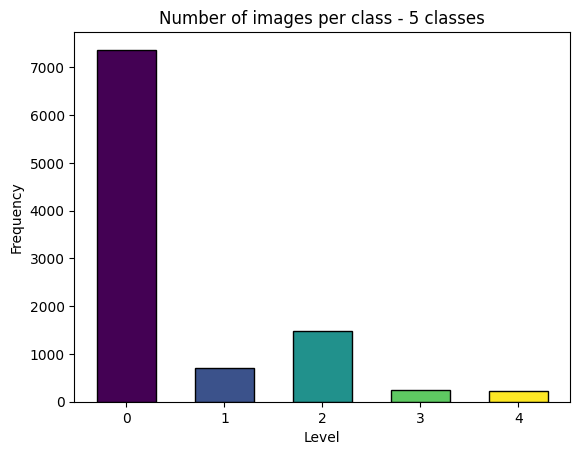

In [ ]:
bins = range(int(retina_df["level"].min()), int(retina_df["level"].max()) + 2)

counts, bins, patches = plt.hist(retina_df["level"], bins=bins, edgecolor='black', rwidth=0.6)

bin_centers = [0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)]
plt.xticks(bin_centers, [str(int(bin_center - 0.5)) for bin_center in bin_centers])

colors = plt.cm.viridis(np.linspace(0, 1, len(patches)))
for patch, color in zip(patches, colors):
    patch.set_facecolor(color)

plt.xlabel('Level')
plt.ylabel('Frequency')
plt.title('Number of images per class - 5 classes')

plt.show()

We decuded to add a binary label:
- 0 indicates that the is healthy
- 1 indicates the presence of diabetic retinopathy (DR)

In [ ]:
retina_df['binary_level'] = retina_df['level'].apply(lambda x: 0 if x == 0 else 1)

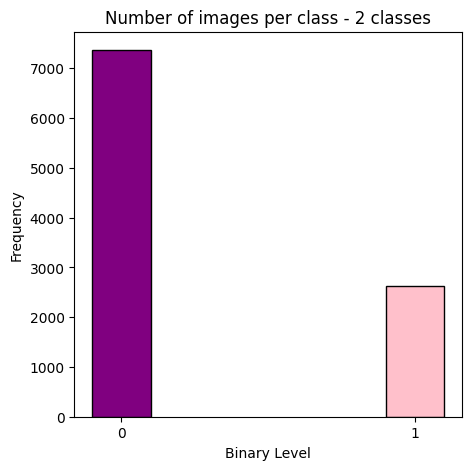

In [ ]:
bins = [0, 1, 2]

fig, ax = plt.subplots(figsize=(5, 5))
counts, bins, patches = ax.hist(retina_df['binary_level'], bins=bins, edgecolor='black', rwidth=0.2, align='mid')

ax.set_xticks([0.5, 1.5])
ax.set_xticklabels([0, 1])

colors = ['purple', 'pink']
for patch, color in zip(patches, colors):
    patch.set_facecolor(color)

ax.set_xlabel('Binary Level')
ax.set_ylabel('Frequency')
ax.set_title('Number of images per class - 2 classes')

plt.show()

In [ ]:
retina_df

,image,level,PatientId,path,exists,eye,level_cat,binary_level
0,10_left,0,10,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,1,"[1, 0, 0, 0, 0]",0
2,13_left,0,13,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,1,"[1, 0, 0, 0, 0]",0
3,13_right,0,13,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,0,"[1, 0, 0, 0, 0]",0
4,15_left,1,15,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,1,"[0, 1, 0, 0, 0]",1
6,16_left,4,16,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,1,"[0, 0, 0, 0, 1]",1
...,...,...,...,...,...,...,...,...
35108,44331_left,0,44331,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,1,"[1, 0, 0, 0, 0]",0
35112,44337_left,1,44337,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,1,"[0, 1, 0, 0, 0]",1
35115,44338_right,0,44338,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,0,"[1, 0, 0, 0, 0]",0
35119,44343_right,0,44343,/content/drive/.shortcut-targets-by-id/1d7g7M2...,True,0,"[1, 0, 0, 0, 0]",0


# **3. Preprocessing**

We preprocessed the images using OpenCV package to:  

1. rescale the images to have the same radius (300 pixels),  

2. subtracted the local average color that gets mapped to 50% gray,  

3. clipped the images to 90% size to remove the boundary effects (the black background around the eye).


First we tried to preprocess one image, then we make a loop to preprocess all images.

In [ ]:
def scaleRadius(img, scale):
    x = img[img.shape[0] // 2, :, :].sum(1)
    r = (x > x.mean() / 10).sum() / 2
    s = scale * 1.0 / r
    return cv2.resize(img, (0, 0), fx=s, fy=s)

scale = 300

for f in glob.glob(base_image_dir):
    try:
        a = cv2.imread(f)
        a = scaleRadius(a, scale)

        a = cv2.addWeighted(a, 4, cv2.GaussianBlur(a, (0, 0), scale/30), -4, 128)

        b = np.zeros(a.shape)
        cv2.circle(b, (a.shape[1] // 2, a.shape[0] // 2), int(scale * 0.9), (1, 1, 1), -1, 8, 0)
        a = a * b + 128 * (1 - b) # a = a * b black

        output_file_path = os.path.join(output_path, os.path.basename(f))

        cv2.imwrite(output_file_path, a)
    except Exception as e:
        print(f, e)

# **4. Models' Setup**

We define a function set_seed to set the random seed. This ensures that our experiments are reproducible.

In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

We define a series of transformations to be applied to the images. These transformations include resizing the images to 224x224 pixels, converting the images to PyTorch tensors, and normalizing the images with specific mean and standard deviation values calculated for our dataset.

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5025, 0.5015, 0.5012], std=[0.0531, 0.0581, 0.0388])
])

These functions handle the image loading and transformation, returning the processed image tensors along with their labels.

In [ ]:
def load_binary(row):
    image_path = row['path']
    if os.path.exists(image_path):
        image = Image.open(image_path).convert('RGB')
        image_tensor = transform(image)
        return image_tensor, row['binary_level']
    return None

def load_5(row):
    image_path = row['path']
    if os.path.exists(image_path):
        image = Image.open(image_path).convert('RGB')
        image_tensor = transform(image)
        return image_tensor, row['level']
    return None

These functions utilize multithreading to efficiently load and transform the images, returning lists of image tensors and labels.

In [ ]:
def create_tensors_binary(df):
    image_tensors = []
    labels = []
    with ThreadPoolExecutor() as executor:
        results = executor.map(load_binary, [row for _, row in df.iterrows()])
        for result in results:
            if result is not None:
                image_tensor, label = result
                image_tensors.append(image_tensor)
                labels.append(label)
    return image_tensors, labels

def create_tensors_5(df):
    image_tensors = []
    labels = []
    with ThreadPoolExecutor() as executor:
        results = executor.map(load_5, [row for _, row in df.iterrows()])
        for result in results:
            if result is not None:
                image_tensor, label = result
                image_tensors.append(image_tensor)
                labels.append(label)
    return image_tensors, labels

def create_tensors_binary(df):
    image_tensors = []
    labels = []
    with ThreadPoolExecutor() as executor:
        results = executor.map(load_binary, [row for _, row in df.iterrows()])
        for result in results:
            if result is not None:
                image_tensor, label = result
                image_tensors.append(image_tensor)
                labels.append(label)
    return image_tensors, labels

Next, we create tensors for binary classification and 5-class classification. Both sections print the shapes of the resulting tensors to verify the data processing.

In [ ]:
image_tensors_bin, labels_bin = create_tensors_binary(retina_df)

images_tensor_bin = torch.stack(image_tensors_bin)
labels_tensor_bin = torch.tensor(labels_bin, dtype=torch.float32)
print(f"Total images binary: {images_tensor_bin.shape}")
print(f"Total labels binary: {labels_tensor_bin.shape}")

Total images binary: torch.Size([10001, 3, 224, 224])
Total labels binary: torch.Size([10001])


In [ ]:
image_tensors_5, labels_5 = create_tensors_5(retina_df)

images_tensor_5 = torch.stack(image_tensors_5)
labels_tensor_5 = torch.tensor(labels_5, dtype=torch.long)
print(f"Total images 5 classes: {images_tensor_5.shape}")
print(f"Total labels 5 classes: {labels_tensor_5.shape}")

Total images 5 classes: torch.Size([10001, 3, 224, 224])
Total labels 5 classes: torch.Size([10001])


In [ ]:
class RetinaDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label

This custom dataset class is essential for using the DataLoader in PyTorch, allowing for easy batching and shuffling of the data.

These next cells split the binary and 5-classes image tensors and labels into training and testing sets, create datasets and DataLoaders for each, and print the shape of the first batch from the training DataLoader.

In [ ]:
train_images, test_images, train_labels, test_labels = train_test_split(images_tensor_bin, labels_tensor_bin, test_size=0.3, random_state=42)

train_dataset = RetinaDataset(train_images, train_labels)
test_dataset = RetinaDataset(test_images, test_labels)

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

for images, labels in train_loader:
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch of labels shape: {labels.shape}")
    break

Batch of images shape: torch.Size([10, 3, 224, 224])
Batch of labels shape: torch.Size([10])


In [ ]:
train_images_5, test_images_5, train_labels_5, test_labels_5 = train_test_split(images_tensor_5, labels_tensor_5, test_size=0.3, random_state=42)

train_dataset_5 = RetinaDataset(train_images_5, train_labels_5)
test_dataset_5 = RetinaDataset(test_images_5, test_labels_5)

train_loader_5 = DataLoader(train_dataset_5, batch_size=10, shuffle=True)
test_loader_5 = DataLoader(test_dataset_5, batch_size=10, shuffle=False)

for images, labels in train_loader_5:
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch of labels shape: {labels.shape}")
    break

Batch of images shape: torch.Size([10, 3, 224, 224])
Batch of labels shape: torch.Size([10])


# **5. VGG16 model - Binary Classification**

In this section, we utilize a pre-trained VGG16 model to perform binary classification. The model is modified to include a custom classifier head, which consists of a linear layer followed by a ReLU activation, dropout for regularization, and another linear layer leading into a Sigmoid activation function. The model is trained using Binary Cross Entropy Loss (BCELoss) and optimized with Stochastic Gradient Descent (SGD).

In [ ]:
set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg16 = models.vgg16(pretrained=True)
for param in vgg16.features.parameters():
    param.requires_grad = False

vgg16.classifier[6] = nn.Sequential(
    nn.Linear(4096, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 1),
    nn.Sigmoid()
)

vgg16 = vgg16.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 220MB/s]


We implement early stopping to prevent overfitting, using a patience of 3 epochs. The learning rate is adjusted dynamically using a ReduceLROnPlateau scheduler, which reduces the learning rate when the validation loss stops improving.

Training and validation losses are recorded and visualized to monitor the learning process.

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1, Loss: 0.5847277082928589
Validation Loss: 0.5738289235438223
Epoch 2, Loss: 0.5753029656410217
Validation Loss: 0.5705101114768919
Epoch 3, Loss: 0.5686272845949445
Validation Loss: 0.5712558423165863
Epoch 4, Loss: 0.5653405220167977
Validation Loss: 0.5652865163511612
Epoch 5, Loss: 0.5630293830590589
Validation Loss: 0.5631786310098496
Epoch 6, Loss: 0.5567857704843794
Validation Loss: 0.5610853298953997
Epoch 7, Loss: 0.5560338133147784
Validation Loss: 0.5589092298599573
Epoch 8, Loss: 0.5527301050083978
Validation Loss: 0.5569609182815615
Epoch 9, Loss: 0.5527873744496278
Validation Loss: 0.5576055854360923
Epoch 10, Loss: 0.5475209242105484
Validation Loss: 0.554966631967364
Epoch 11, Loss: 0.5435906061104365
Validation Loss: 0.5520736381065013
Epoch 12, Loss: 0.539318313151598
Validation Loss: 0.5516464543897052


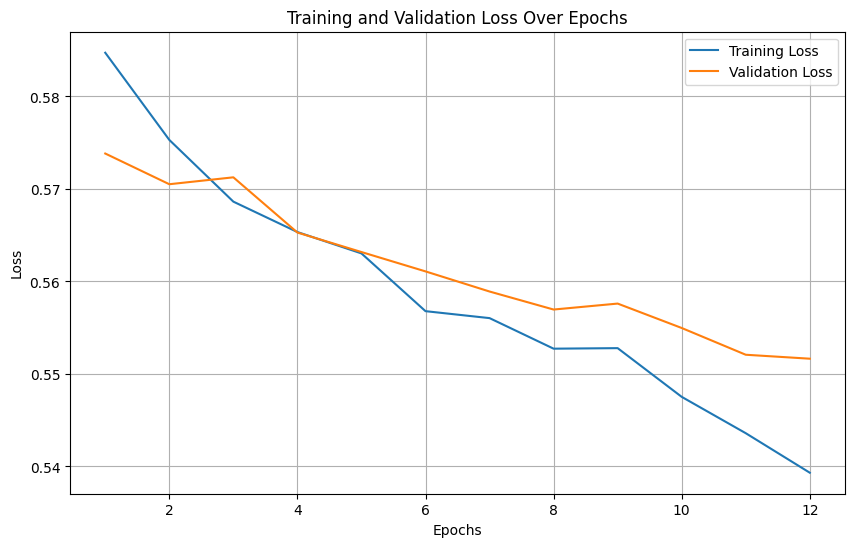

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

patience = 3
early_stopping_counter = 0
previous_val_loss = float('inf')

train_losses = []
val_losses = []

for epoch in range(12):
    vgg16.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float()
        optimizer.zero_grad()
        outputs = vgg16(images)
        outputs = outputs.squeeze(dim=1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    print(f"Epoch {epoch+1}, Loss: {train_loss}")

    vgg16.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).float()
            outputs = vgg16(images)
            outputs = outputs.squeeze(dim=1)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss /= len(test_loader)
    val_losses.append(val_loss)
    print(f"Validation Loss: {val_loss}")

    scheduler.step(val_loss)

    if val_loss < previous_val_loss:
        previous_val_loss = val_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("Early stopping triggered")
            break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

The training and validation loss graphs indicate that the model is effectively learning and not overfitting significantly, although there is a small degree of variability in the validation loss.

Additionally, we evaluate the model's performance on both training and test sets by calculating accuracy and plotting a confusion matrix to visualize classification performance.

In [ ]:
vgg16.eval()
with torch.no_grad():
    correct, total = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float()
        outputs = vgg16(images).squeeze()
        predicted = outputs.round()
        if predicted.dim() == 0:
            predicted = predicted.unsqueeze(0)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    final_train_acc = correct / total
    print("Training accuracy:", final_train_acc * 100)

with torch.no_grad():
    correct, total = 0, 0
    all_preds = []
    all_labels = []
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device).float()
        outputs = vgg16(images).squeeze()
        predicted = outputs.round()
        if predicted.dim() == 0:
            predicted = predicted.unsqueeze(0)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy().tolist())
        all_labels.extend(labels.cpu().numpy().tolist())
    test_acc = correct / total
    print("Test accuracy:", test_acc * 100)

Training accuracy: 76.11428571428571
Test accuracy: 74.80839720093302


The training and test accuracies suggest that the model generalizes well from the training data to unseen test data.

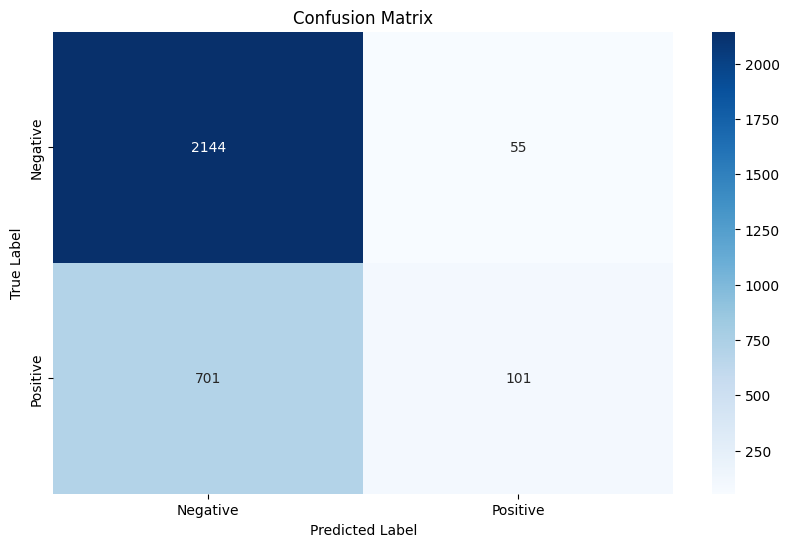

In [ ]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

The confusion matrix shows that while the model is good at predicting negative instances, it has a higher rate of false negatives (701) compared to true positives (101), suggesting that the model struggles more with positive class predictions. This is due to the class imbalance.

# **6. VGG16 model - 5 Classes**

In this section, we adapt the VGG16 model for multi-class classification, where the task is to classify images into one of five distinct classes. Similar to the binary classifier, the VGG16 model is pre-trained, and its classifier head is replaced with a custom architecture. This custom head includes a linear layer followed by a ReLU activation, dropout for regularization, and a final linear layer with a Softmax activation to output probabilities for each of the five classes. The model is trained using Cross Entropy Loss and optimized with SGD.


In [ ]:
set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg16_5 = models.vgg16(pretrained=True)
for param in vgg16_5.features.parameters():
    param.requires_grad = False

vgg16_5.classifier[6] = nn.Sequential(
    nn.Linear(4096, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 5),
    nn.Softmax(dim=1)
)

vgg16_5 = vgg16_5.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Early stopping is also implemented here to avoid overfitting, with a patience of 3 epochs. A ReduceLROnPlateau scheduler dynamically adjusts the learning rate based on validation loss improvements.

We record and plot training and validation losses to assess the model's learning trajectory.

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1, Loss: 1.2184224200248719
Validation Loss: 1.1728149181188539
Epoch 2, Loss: 1.1683059413943973
Validation Loss: 1.1718308333542655
Epoch 3, Loss: 1.1674742877483368
Validation Loss: 1.171585788164424
Epoch 4, Loss: 1.1671441184622902
Validation Loss: 1.1714820596466824
Epoch 5, Loss: 1.1670365420409612
Validation Loss: 1.1714249435453319
Epoch 6, Loss: 1.1669086606161936
Validation Loss: 1.171390586913226
Epoch 7, Loss: 1.1668511130128587
Validation Loss: 1.1713680676447593
Epoch 8, Loss: 1.1667936988387788
Validation Loss: 1.171352500733347
Epoch 9, Loss: 1.1667874354975565
Validation Loss: 1.1713512036887515
Epoch 10, Loss: 1.1667784242970602
Validation Loss: 1.1713499375355996
Epoch 11, Loss: 1.1667969344343458
Validation Loss: 1.171348640292982
Epoch 12, Loss: 1.1667821090562003
Validation Loss: 1.1713485765298737


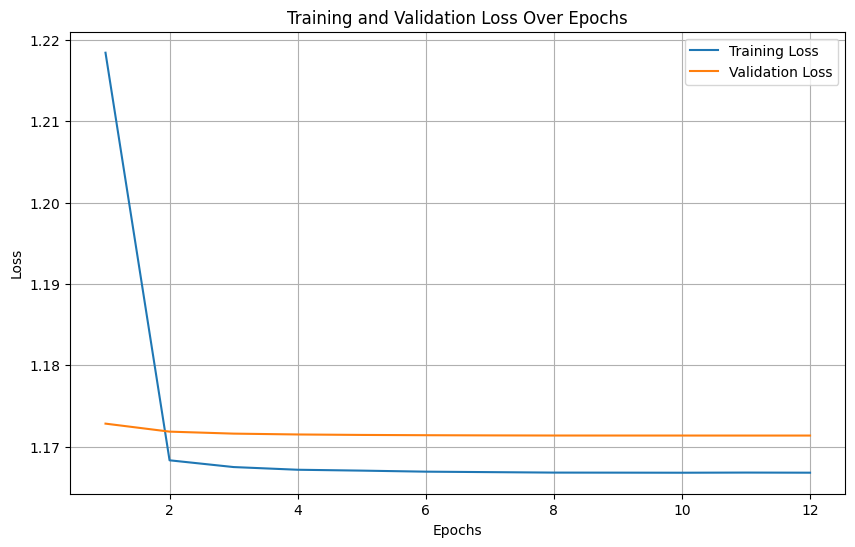

In [ ]:
criterion_5 = nn.CrossEntropyLoss()
optimizer_5 = optim.SGD(vgg16_5.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-4)

scheduler_5 = ReduceLROnPlateau(optimizer_5, mode='min', factor=0.1, patience=3, verbose=True)

patience_5 = 3
early_stopping_counter_5 = 0
previous_val_loss_5 = float('inf')

train_losses_5 = []
val_losses_5 = []

for epoch in range(12):
    vgg16_5.train()
    running_loss_5 = 0.0
    for images, labels in train_loader_5:
        images, labels = images.to(device), labels.to(device)
        optimizer_5.zero_grad()
        outputs = vgg16_5(images)
        outputs = outputs.squeeze(dim=1)
        loss = criterion_5(outputs, labels)
        loss.backward()
        optimizer_5.step()
        running_loss_5 += loss.item()

    train_loss_5 = running_loss_5 / len(train_loader_5)
    train_losses_5.append(train_loss_5)
    print(f"Epoch {epoch+1}, Loss: {train_loss_5}")

    vgg16_5.eval()
    val_loss_5 = 0.0
    with torch.no_grad():
        for images, labels in test_loader_5:
            images, labels = images.to(device), labels.to(device)
            outputs = vgg16_5(images)
            outputs = outputs.squeeze(dim=1)
            loss = criterion_5(outputs, labels)
            val_loss_5 += loss.item()

    val_loss_5 /= len(test_loader_5)
    val_losses_5.append(val_loss_5)
    print(f"Validation Loss: {val_loss_5}")

    scheduler_5.step(val_loss_5)

    if val_loss_5 < previous_val_loss_5:
        previous_val_loss_5 = val_loss_5
        early_stopping_counter_5 = 0
    else:
        early_stopping_counter_5 += 1
        if early_stopping_counter_5 >= patience_5:
            print("Early stopping triggered")
            break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses_5) + 1), train_losses_5, label='Training Loss')
plt.plot(range(1, len(val_losses_5) + 1), val_losses_5, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

The training and validation loss graphs indicate that the model quickly learns from the training data but reaches a plateau where further improvements are minimal.

Performance evaluation is done by calculating accuracy on the training and test sets and generating a confusion matrix to provide insights into the classification accuracy across different classes.

In [ ]:
vgg16_5.eval()
with torch.no_grad():
    correct_5, total_5 = 0, 0
    for images, labels in train_loader_5:
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16_5(images)
        _, predicted = torch.max(outputs, 1)
        total_5 += labels.size(0)
        correct_5 += (predicted == labels).sum().item()
    final_train_acc_5 = correct_5 / total_5
    print("Training accuracy:", final_train_acc_5 * 100)

with torch.no_grad():
    correct_5, total_5 = 0, 0
    all_preds_5 = []
    all_labels_5 = []
    for images, labels in test_loader_5:
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16_5(images)
        _, predicted = torch.max(outputs, 1)
        total_5 += labels.size(0)
        correct_5 += (predicted == labels).sum().item()
        all_preds_5.extend(predicted.cpu().numpy())
        all_labels_5.extend(labels.cpu().numpy())
    test_acc_5 = correct_5 / total_5
    print("Test accuracy:", test_acc_5 * 100)

Training accuracy: 73.82857142857144
Test accuracy: 73.27557480839721


The training and test accuracies being close suggests that the model generalizes reasonably well, but this accuracy primarily reflects the high performance on class 0 as seen from the following confusion matrix.

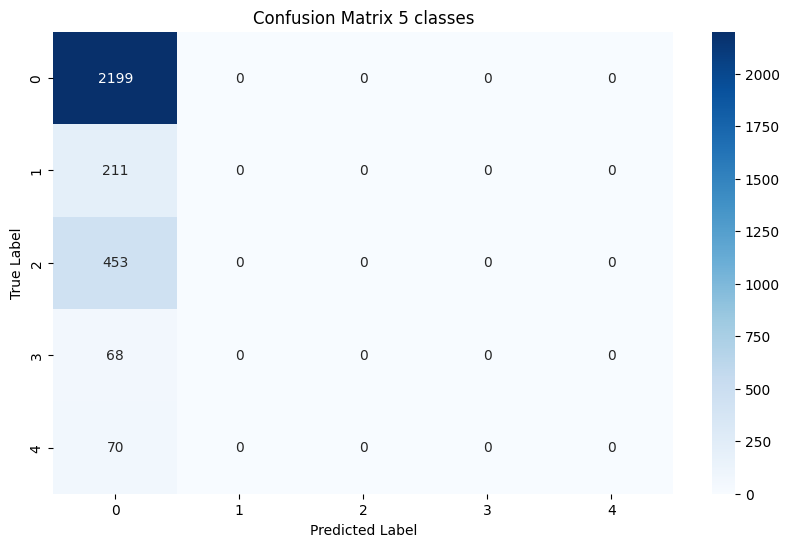

In [ ]:
cm_5 = confusion_matrix(all_labels_5, all_preds_5)

plt.figure(figsize=(10, 6))
sns.heatmap(cm_5, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1', '2', '3', '4'], yticklabels=['0', '1', '2', '3', '4'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix 5 classes')
plt.show()

The confusion matrix shows a clear issue: the model heavily favors class 0 and fails to correctly classify any instances from the other classes. This suggests a problem with class imbalance.

# **7. AlexNet Binary Classification**

In this section, we utilize a pre-trained AlexNet model to perform binary classification. The model is modified to include a custom classifier head, which consists of a linear layer followed by a ReLU activation, dropout for regularization, and another linear layer, followed by a Sigmoid function to ensure binary output. The model is trained using Binary Cross Entropy Loss (BCELoss) and optimized with Stochastic Gradient Descent (SGD).

In [ ]:
set_seed(42)

alexnet = models.alexnet(pretrained=True)
for param in alexnet.features.parameters():
    param.requires_grad = False

alexnet.classifier[6] = nn.Sequential(
    nn.Linear(alexnet.classifier[6].in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 1)
    nn.Sigmoid()
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet = alexnet.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:14<00:00, 16.5MB/s]


We implement early stopping to prevent overfitting, using a patience of 3 epochs. The learning rate is adjusted dynamically using a ReduceLROnPlateau scheduler, which reduces the learning rate when the validation loss stops improving.

In [ ]:
criterion_a = nn.BCEWithLogitsLoss()
optimizer_a = optim.SGD(alexnet.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-4)
scheduler_a = ReduceLROnPlateau(optimizer_a, 'min', patience=3, verbose=True)

best_test_loss_a = float('inf')
patience_a = 3
trigger_times_a = 0

num_epochs = 12
train_losses_a = []
train_accuracies_a = []
test_losses_a = []
test_accuracies_a = []

for epoch in range(num_epochs):
    alexnet.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
        optimizer_a.zero_grad()
        outputs = alexnet(images)
        loss = criterion_a(outputs, labels)
        loss.backward()
        optimizer_a.step()

        running_loss += loss.item() * images.size(0)

        preds = torch.sigmoid(outputs).round()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct / total
    train_losses_a.append(epoch_loss)
    train_accuracies_a.append(epoch_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")
    scheduler_a.step(epoch_loss)

    alexnet.eval()
    test_running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            outputs = alexnet(images)
            loss = criterion_a(outputs, labels)
            test_running_loss += loss.item() * images.size(0)
            preds = torch.sigmoid(outputs).round()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    test_loss = test_running_loss / len(test_loader.dataset)
    test_accuracy = correct / total
    test_losses_a.append(test_loss)
    test_accuracies_a.append(test_accuracy)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    if test_loss < best_test_loss_a:
        best_test_loss_a = test_loss
        trigger_times_a = 0
    else:
        trigger_times_a += 1
        if trigger_times_a >= patience_a:
            print(f"Early stopping at epoch {epoch+1}")
            break

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/12, Loss: 0.5809, Accuracy: 0.7359
Test Loss: 0.5640, Test Accuracy: 0.7398
Epoch 2/12, Loss: 0.5653, Accuracy: 0.7420
Test Loss: 0.5723, Test Accuracy: 0.7458
Epoch 3/12, Loss: 0.5572, Accuracy: 0.7476
Test Loss: 0.5604, Test Accuracy: 0.7434
Epoch 4/12, Loss: 0.5481, Accuracy: 0.7524
Test Loss: 0.5621, Test Accuracy: 0.7418
Epoch 5/12, Loss: 0.5514, Accuracy: 0.7500
Test Loss: 0.5645, Test Accuracy: 0.7481
Epoch 6/12, Loss: 0.5504, Accuracy: 0.7494
Test Loss: 0.5587, Test Accuracy: 0.7461
Epoch 7/12, Loss: 0.5429, Accuracy: 0.7514
Test Loss: 0.5559, Test Accuracy: 0.7481
Epoch 8/12, Loss: 0.5398, Accuracy: 0.7526
Test Loss: 0.5671, Test Accuracy: 0.7491
Epoch 9/12, Loss: 0.5373, Accuracy: 0.7530
Test Loss: 0.5635, Test Accuracy: 0.7521
Epoch 10/12, Loss: 0.5366, Accuracy: 0.7534
Test Loss: 0.5577, Test Accuracy: 0.7514
Early stopping at epoch 10


We evaluate the model both on training and test data and we visualize the loss.

In [ ]:
alexnet.eval()
with torch.no_grad():
    correct, total = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
        outputs = alexnet(images)
        predicted = torch.sigmoid(outputs).round()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    final_train_acc_a = correct / total
    print("Training accuracy:", final_train_acc_a * 100)

all_preds_a = []
all_labels_a = []
with torch.no_grad():
    correct, total = 0, 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
        outputs = alexnet(images)
        predicted = torch.sigmoid(outputs).round()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        all_preds_a.extend(predicted.cpu().numpy().tolist())
        all_labels_a.extend(labels.cpu().numpy().tolist())
    test_acc = correct / total
    print("Test accuracy:", test_acc * 100)

Training accuracy: 76.3
Test accuracy: 75.14161946017994


Both percentages are pretty high and not too far between each others, which in principle should be good.

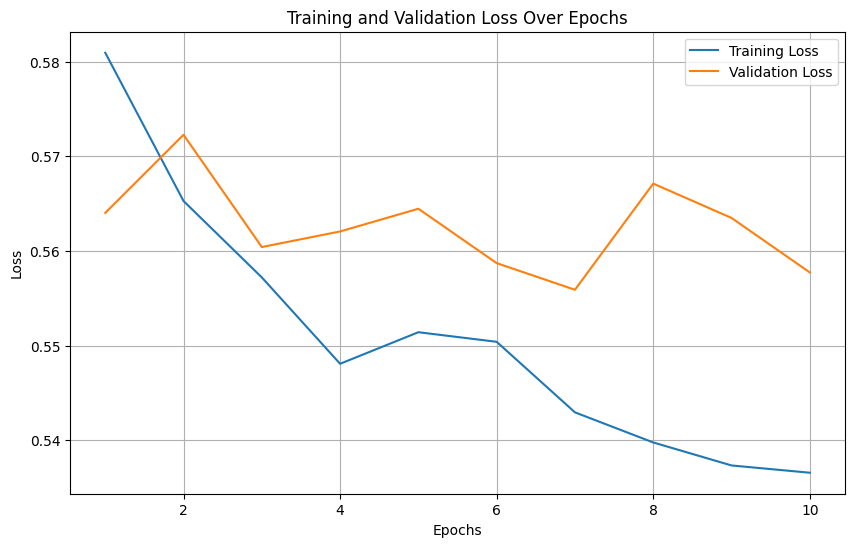

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses_a) + 1), train_losses_a, label='Training Loss')
plt.plot(range(1, len(test_losses_a) + 1), test_losses_a, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

The training loss graphs indicate that the model is effectively learning and not overfitting significantly, although the validation loss oscillates and doesn't show a decreasing pattern. Let's visualize a confusion matrix of the results to understand them.

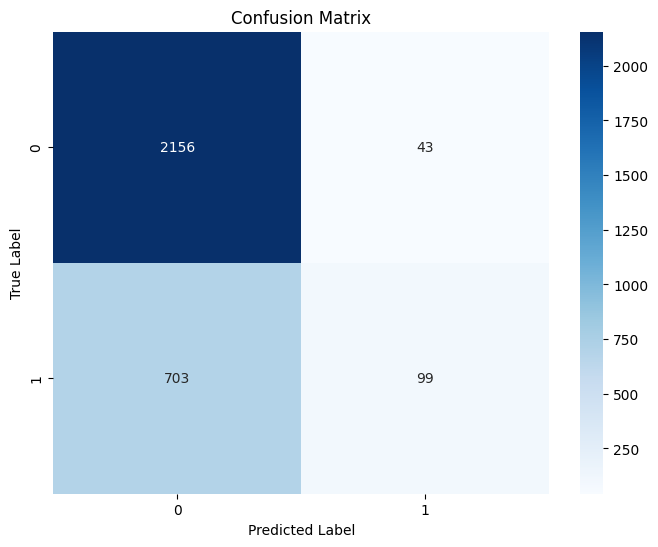

In [ ]:
cm_a = confusion_matrix(all_labels_a, all_preds_a)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_a, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

We see that the model misclassifies most of the "non-healthy" eyes as "healthy". Therefore, the model doesn't perform well, probably to due unbalancedness.

# **8. AlexNet - 5 classes**

In this section, we adapt the pretrained AlexNet model for multi-class classification, where the task is to classify images into one of five distinct classes. Its classifier head is replaced with a custom architecture. This custom head includes a linear layer followed by a ReLU activation, dropout for regularization, and a final linear. The model is trained using Cross Entropy Loss and optimized with SGD.


In [ ]:
set_seed(42)

alexnet = models.alexnet(pretrained=True)
for param in alexnet.features.parameters():
    param.requires_grad = False

alexnet.classifier[6] = nn.Sequential(
    nn.Linear(alexnet.classifier[6].in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 5)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet = alexnet.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:00<00:00, 383MB/s]


Early stopping is also implemented here to avoid overfitting, with a patience of 3 epochs. A ReduceLROnPlateau scheduler dynamically adjusts the learning rate based on validation loss improvements.

In [ ]:
criterion_a_5 = nn.CrossEntropyLoss()
optimizer_a_5 = optim.Adam(alexnet.parameters(), lr=0.0001)
scheduler_a_5 = ReduceLROnPlateau(optimizer_a_5, 'min', patience=3, verbose=True)

num_epochs = 10
train_losses_a_5 = []
train_accuracies_a_5 = []
test_losses_a_5 = []
test_accuracies_a_5 = []

best_test_loss_a_5 = float('inf')
patience_a_5 = 3
trigger_times_a_5 = 0

for epoch in range(num_epochs):
    alexnet.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader_5:
        images, labels = images.to(device), labels.to(device)

        optimizer_a_5.zero_grad()

        outputs = alexnet(images)
        loss = criterion_a_5(outputs, labels)

        loss.backward()
        optimizer_a_5.step()

        running_loss += loss.item() * images.size(0)

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader_5.dataset)
    epoch_accuracy = correct / total
    train_losses_a_5.append(epoch_loss)
    train_accuracies_a_5.append(epoch_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")
    scheduler_a_5.step(epoch_loss)

    alexnet.eval()
    test_running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader_5:
            images, labels = images.to(device), labels.to(device)
            outputs = alexnet(images)
            loss = criterion_a_5(outputs, labels)
            test_running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy().tolist())
            all_labels.extend(labels.cpu().numpy().tolist())

    test_loss = test_running_loss / len(test_loader_5.dataset)
    test_accuracy = correct / total
    test_losses_a_5.append(test_loss)
    test_accuracies_a_5.append(test_accuracy)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    if test_loss < best_test_loss_a_5:
        best_test_loss_a_5 = test_loss
        trigger_times_a_5 = 0
    else:
        trigger_times_a_5 += 1
        if trigger_times_a_5 >= patience_a_5:
            print(f"Early stopping at epoch {epoch+1}")
            break

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/10, Loss: 0.9042, Accuracy: 0.7340
Test Loss: 0.8493, Test Accuracy: 0.7341
Epoch 2/10, Loss: 0.8386, Accuracy: 0.7421
Test Loss: 0.8322, Test Accuracy: 0.7374
Epoch 3/10, Loss: 0.8084, Accuracy: 0.7421
Test Loss: 0.8532, Test Accuracy: 0.7348
Epoch 4/10, Loss: 0.7868, Accuracy: 0.7459
Test Loss: 0.8381, Test Accuracy: 0.7378
Epoch 5/10, Loss: 0.7624, Accuracy: 0.7457
Test Loss: 0.8492, Test Accuracy: 0.7374
Early stopping at epoch 5


Performance evaluation is done by calculating accuracy on the training and test sets and generating a confusion matrix to provide insights into the classification accuracy across different classes.

In [ ]:
alexnet.eval()
with torch.no_grad():
    correct, total = 0, 0
    for images, labels in train_loader_5:
        images, labels = images.to(device), labels.to(device)
        outputs = alexnet(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    final_train_acc_a_5 = correct / total
    print("Training accuracy:", final_train_acc_a_5 * 100)

all_preds_a_5 = []
all_labels_a_5 = []
with torch.no_grad():
    correct, total = 0, 0
    for images, labels in test_loader_5:
        images, labels = images.to(device), labels.to(device)
        outputs = alexnet(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        all_preds_a_5.extend(preds.cpu().numpy().tolist())
        all_labels_a_5.extend(labels.cpu().numpy().tolist())
    test_acc_a_5 = correct / total
    print("Test accuracy:", test_acc_a_5 * 100)

Training accuracy: 76.04285714285714
Test accuracy: 73.74208597134289


The training and test accuracies being close suggests that the model generalizes reasonably well, but this accuracy primarily reflects the high performance on class 0 as we'll see later with the confusion matrix.

We record and plot training and validation losses to assess the model's learning trajectory.

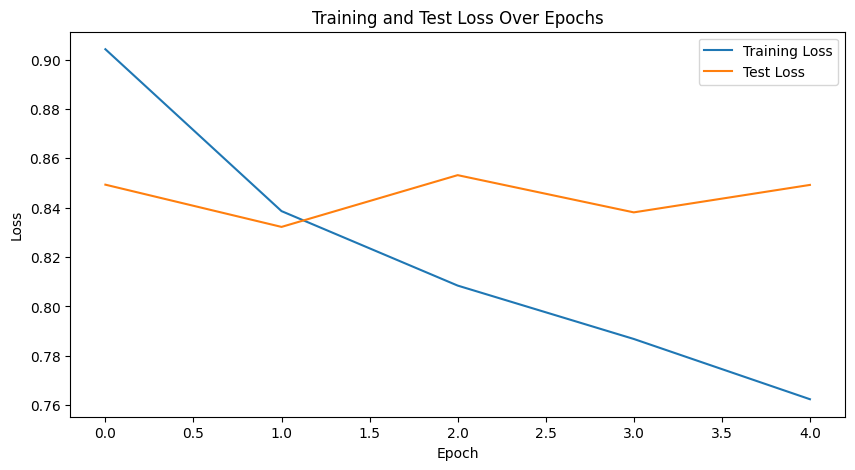

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses_a_5, label='Training Loss')
plt.plot(test_losses_a_5, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.show()

The training and validation loss graphs indicate that the model learns from the training data, however,r we encounter variability and minimal improvements on the test loss.

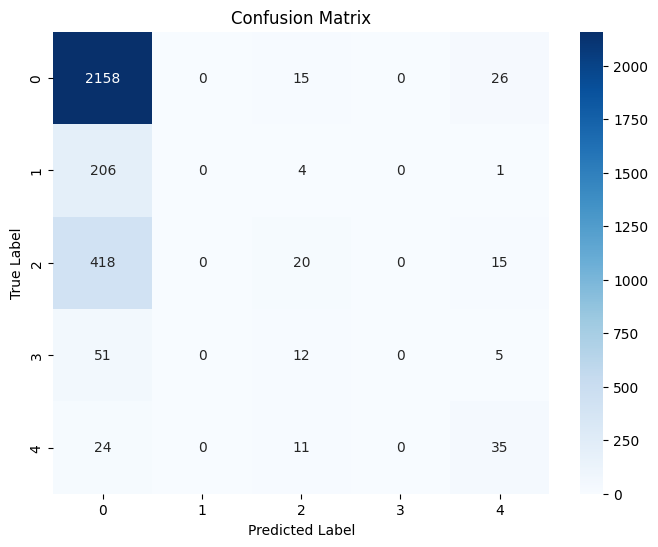

In [ ]:
cm_a_5 = confusion_matrix(all_labels_a_5, all_preds_a_5)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_a_5, annot=True, fmt="d", cmap="Blues", xticklabels=range(5), yticklabels=range(5))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

The confusion matrix shows a clear issue: the model heavily favors class 0 and fails to correctly classify most instances from other classes. This suggests a problem with class imbalance.

# **9. GoogleLeNet - Binary Classification**

In this section, we utilize a pre-trained GoogleNet model to perform binary classification. The model is adapted to include a custom classifier head, replacing the original fully connected layer with a new one tailored for binary output. We employ Binary Cross Entropy with Logits Loss (BCEWithLogitsLoss) and optimize the model using Stochastic Gradient Descent (SGD).

In [ ]:
set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

googlenet = models.googlenet(pretrained=True)

for param in googlenet.parameters():
    param.requires_grad = False

num_ftrs = googlenet.fc.in_features
googlenet.fc = nn.Linear(num_ftrs, 1)
googlenet.aux_logits = False

googlenet = googlenet.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(googlenet.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 167MB/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.w

We implement early stopping to avoid overfitting, with a patience of 3 epochs. A ReduceLROnPlateau scheduler is used to dynamically adjust the learning rate when the validation loss plateaus.

In [ ]:
patience = 3
early_stopping_counter = 0
previous_val_loss = float('inf')

train_losses = []
val_losses = []

for epoch in range(12):
    googlenet.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
        optimizer.zero_grad()
        outputs = googlenet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    print(f"Epoch {epoch+1}, Loss: {train_loss}")

    googlenet.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            outputs = googlenet(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss /= len(test_loader)
    val_losses.append(val_loss)
    print(f"Validation Loss: {val_loss}")

    scheduler.step(val_loss)

    if val_loss < previous_val_loss:
        previous_val_loss = val_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("Early stopping triggered")
            break

Epoch 1, Loss: 0.576108672278268
Validation Loss: 0.5717881616959937
Epoch 2, Loss: 0.5667843294995172
Validation Loss: 0.5662952193192073
Epoch 3, Loss: 0.5603585680893489
Validation Loss: 0.5605901497543057
Epoch 4, Loss: 0.5580325012547629
Validation Loss: 0.5578522615852546
Epoch 5, Loss: 0.5532836764199394
Validation Loss: 0.5547945100405683
Epoch 6, Loss: 0.5534344815782138
Validation Loss: 0.554593110401369
Epoch 7, Loss: 0.5499231258034706
Validation Loss: 0.5516388117276949
Epoch 8, Loss: 0.5479451012185642
Validation Loss: 0.5495774292470609
Epoch 9, Loss: 0.5458656411937305
Validation Loss: 0.5485614937207232
Epoch 10, Loss: 0.5463505781122616
Validation Loss: 0.5478417272880624
Epoch 11, Loss: 0.5444787916328225
Validation Loss: 0.5491979267213035
Epoch 12, Loss: 0.5434448292425701
Validation Loss: 0.5452544568880056


The training and validation loss graphs reveal that the model is learning effectively and not overfitting, although slight fluctuations in validation loss are observed.

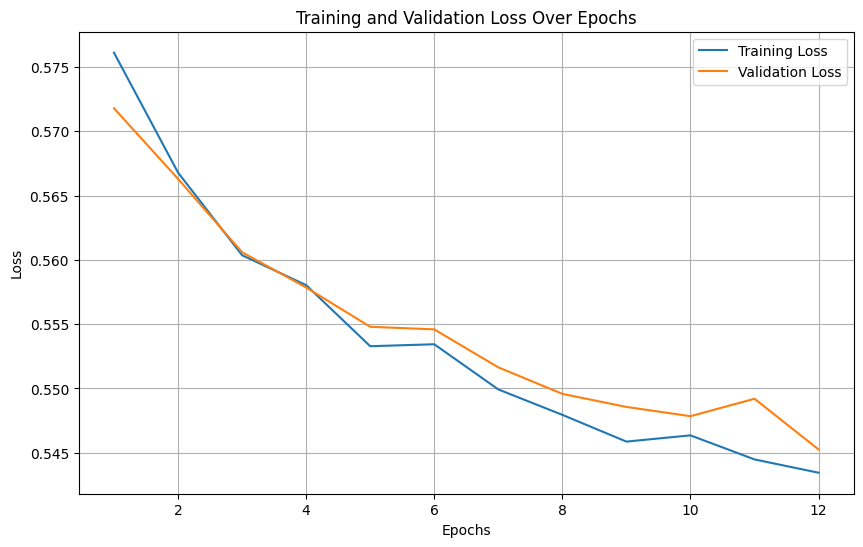

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Additionally, the model's performance is evaluated on both training and test sets by calculating accuracy. The training and test accuracies demonstrate that the model generalizes well from the training data to unseen test data.

In [ ]:
googlenet.eval()
with torch.no_grad():
    correct, total = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float()
        outputs = googlenet(images).squeeze()
        predicted = torch.round(torch.sigmoid(outputs))
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    final_train_acc = correct / total
    print("Training accuracy:", final_train_acc * 100)

    correct, total = 0, 0
    all_preds = []
    all_labels = []
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device).float()
        outputs = googlenet(images).squeeze()
        predicted = torch.round(torch.sigmoid(outputs))

        if predicted.dim() == 0:
            predicted = predicted.unsqueeze(0)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy().tolist())
        all_labels.extend(labels.cpu().numpy().tolist())
    test_acc = correct / total
    print("Test accuracy:", test_acc * 100)

Training accuracy: 75.02857142857144
Test accuracy: 74.80839720093302


The confusion matrix indicates that while the model performs well in predicting negative instances, it exhibits a higher false-negative rate compared to true positives, reflecting the challenges posed by class imbalance.

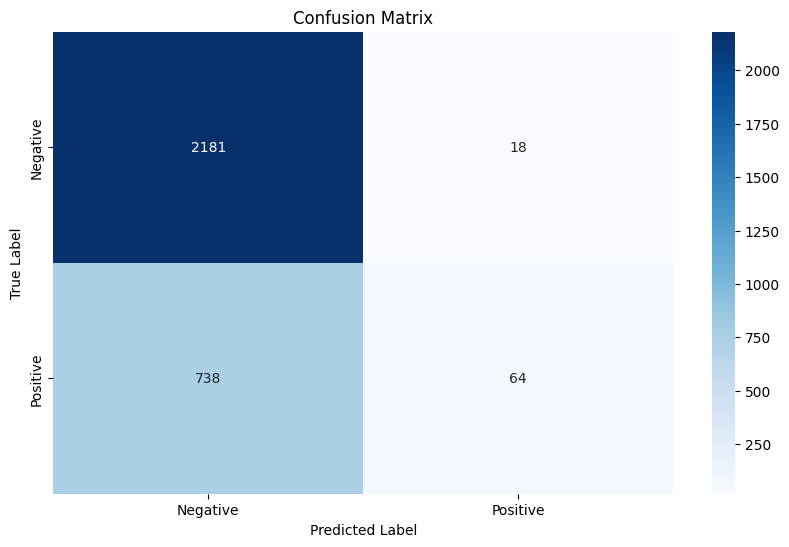

In [ ]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# **10. GoogleLeNet - 5 Classes**


In this section, we employ a pre-trained GoogleLeNet model for a multiclass classification task with five classes. The model's final fully connected layer is replaced with a custom classifier head, consisting of two linear layers separated by ReLU activation and dropout for regularization, followed by a softmax activation to output class probabilities.

In [ ]:
set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

googlenet = models.googlenet(pretrained=True)
for param in googlenet.parameters():
    param.requires_grad = False

googlenet.fc = nn.Sequential(
    nn.Linear(googlenet.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 5),
    nn.Softmax(dim=1)
)

googlenet = googlenet.to(device)

criterion_5 = nn.CrossEntropyLoss()
optimizer_5 = optim.SGD(googlenet.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-4)
scheduler_5 = ReduceLROnPlateau(optimizer_5, mode='min', factor=0.1, patience=2, verbose=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:05<00:00, 9.51MB/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.

We iterated over the dataset for 12 epochs, adjusting model parameters based on backpropagation. Doing so, we monitored training and validation loss and accuracy, implementing early stopping to prevent overfitting. The results are visualized through loss curves, ensuring effective training for the ML project.

Epoch 1, Loss: 1.354907940200397, Accuracy: 0.7057142857142857
Validation Loss: 1.2025988527791813, Accuracy: 0.732755748083972
Epoch 2, Loss: 1.1834808646781103, Accuracy: 0.7382857142857143
Validation Loss: 1.1813151474119783, Accuracy: 0.732755748083972
Epoch 3, Loss: 1.1734987005165645, Accuracy: 0.7382857142857143
Validation Loss: 1.1766832898712603, Accuracy: 0.732755748083972
Epoch 4, Loss: 1.1708096534865242, Accuracy: 0.7382857142857143
Validation Loss: 1.1749285598549593, Accuracy: 0.732755748083972
Epoch 5, Loss: 1.1695761547769818, Accuracy: 0.7382857142857143
Validation Loss: 1.1743266245239141, Accuracy: 0.732755748083972
Epoch 6, Loss: 1.1688330895560128, Accuracy: 0.7382857142857143
Validation Loss: 1.173942829838835, Accuracy: 0.732755748083972
Epoch 7, Loss: 1.168396212032863, Accuracy: 0.7382857142857143
Validation Loss: 1.173660105047763, Accuracy: 0.732755748083972
Epoch 8, Loss: 1.1681161529677255, Accuracy: 0.7382857142857143
Validation Loss: 1.173221040749224, A

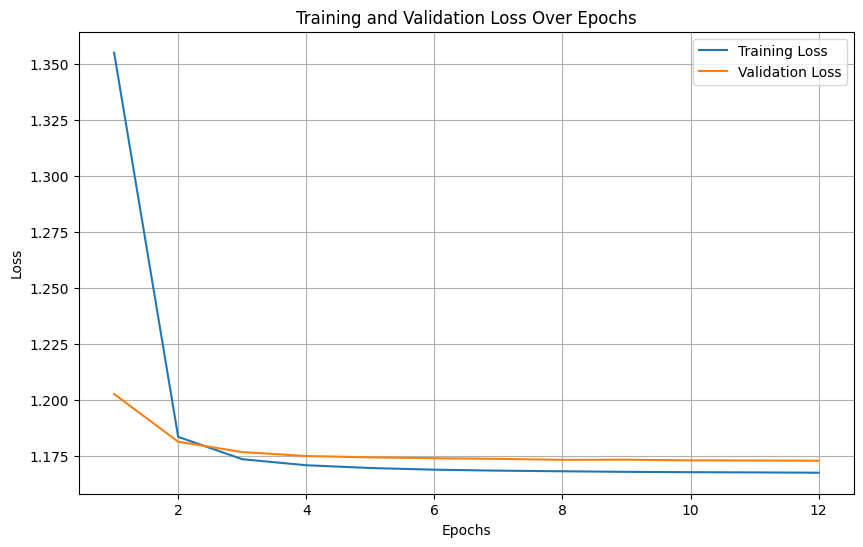

In [ ]:
patience_5 = 3
early_stopping_counter_5 = 0
previous_val_loss_5 = float('inf')

train_losses_5 = []
val_losses_5 = []
train_accuracies_5 = []
val_accuracies_5 = []

def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    corrects = torch.sum(preds == labels.data)
    return corrects.double() / labels.size(0)

for epoch in range(12):
    googlenet.train()
    running_loss_5 = 0.0
    running_corrects_5 = 0
    for images, labels in train_loader_5:
        images, labels = images.to(device), labels.to(device)
        optimizer_5.zero_grad()
        outputs = googlenet(images)
        loss = criterion_5(outputs, labels)
        loss.backward()
        optimizer_5.step()
        running_loss_5 += loss.item() * images.size(0)
        running_corrects_5 += torch.sum(torch.max(outputs, 1)[1] == labels.data)

    train_loss_5 = running_loss_5 / len(train_loader_5.dataset)
    train_accuracy_5 = running_corrects_5.double() / len(train_loader_5.dataset)
    train_losses_5.append(train_loss_5)
    train_accuracies_5.append(train_accuracy_5)
    print(f"Epoch {epoch+1}, Loss: {train_loss_5}, Accuracy: {train_accuracy_5}")

    googlenet.eval()
    val_loss_5 = 0.0
    val_corrects_5 = 0
    with torch.no_grad():
        for images, labels in test_loader_5:
            images, labels = images.to(device), labels.to(device)
            outputs = googlenet(images)
            loss = criterion_5(outputs, labels)
            val_loss_5 += loss.item() * images.size(0)
            val_corrects_5 += torch.sum(torch.max(outputs, 1)[1] == labels.data)

    val_loss_5 /= len(test_loader_5.dataset)
    val_accuracy_5 = val_corrects_5.double() / len(test_loader_5.dataset)
    val_losses_5.append(val_loss_5)
    val_accuracies_5.append(val_accuracy_5)
    print(f"Validation Loss: {val_loss_5}, Accuracy: {val_accuracy_5}")

    scheduler_5.step(val_loss_5)

    if val_loss_5 < previous_val_loss_5:
        previous_val_loss_5 = val_loss_5
        early_stopping_counter_5 = 0
    else:
        early_stopping_counter_5 += 1
        if early_stopping_counter_5 >= patience_5:
            print("Early stopping triggered")
            break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses_5) + 1), train_losses_5, label='Training Loss')
plt.plot(range(1, len(val_losses_5) + 1), val_losses_5, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

As it can be seen in the image above, the plot displays a rapid decrease in training loss eventually reaching constant values. The test loss instead does not seem to decrease significantly. This indicates that the model's performance did not improve significantly during training and validation.

This can be also seen in the following confusion matrix, in which is clear that the model classifies all images as 0. This, as suggested by the analysis of previous models, can be due to calss imbalance.

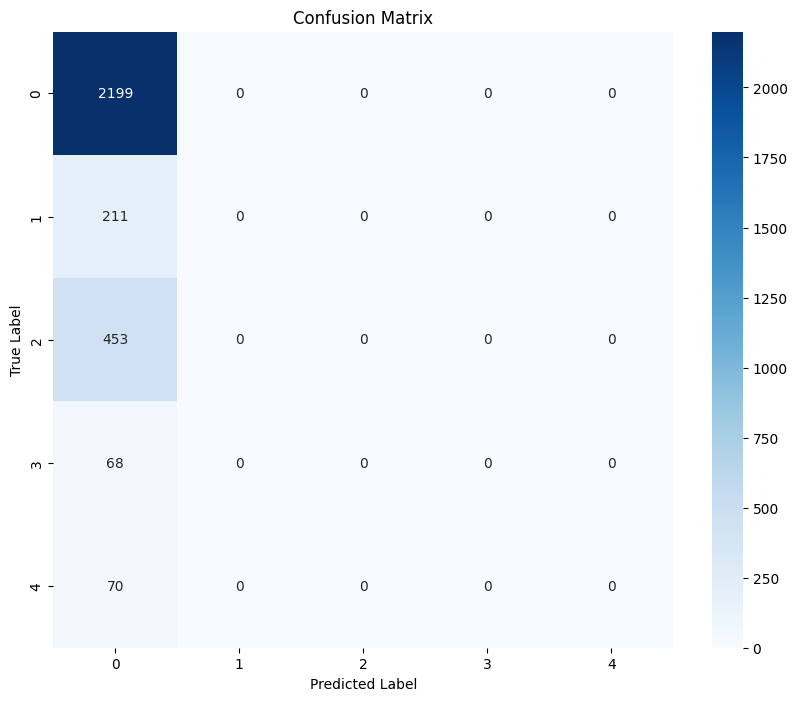

In [ ]:
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader_5:
        images, labels = images.to(device), labels.to(device)
        outputs = googlenet(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# **11. Random Model - Binary Classification**

In this section, we performed binary classification using a random model.

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

num_classes = 2

correct_random_train = 0
total_random_train = 0
for images, labels in train_loader:
    batch_size = labels.size(0)
    random_outputs = torch.rand(batch_size, num_classes)
    _, predicted = torch.max(random_outputs, 1)
    total_random_train += labels.size(0)
    correct_random_train += (predicted == labels).sum().item()

train_acc_random = correct_random_train / total_random_train
print("Random model training accuracy:", train_acc_random * 100)

correct_random_test = 0
total_random_test = 0
all_preds_random = []
all_labels_random = []
for images, labels in test_loader:
    batch_size = labels.size(0)
    random_outputs = torch.rand(batch_size, num_classes)
    _, predicted = torch.max(random_outputs, 1)
    total_random_test += labels.size(0)
    correct_random_test += (predicted == labels).sum().item()
    all_preds_random.extend(predicted.cpu().numpy())
    all_labels_random.extend(labels.cpu().numpy())

test_acc_random = correct_random_test / total_random_test
print("Random model test accuracy:", test_acc_random * 100)

Random model training accuracy: 50.328571428571436
Random model test accuracy: 50.18327224258581


The comparative analysis shows that the pre-trained models for binary classification, despite their flaws, perform significantly better than this random model.

The trained models demonstrate better learning, higher accuracy, and less randomness.

# **12. Random Model - 5 Classes**


In this section, we performed 5 class classificationses classification using a random model.

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

num_classes = 5

correct_random_train = 0
total_random_train = 0
for images, labels in train_loader_5:
    batch_size = labels.size(0)
    random_outputs = torch.rand(batch_size, num_classes)
    _, predicted = torch.max(random_outputs, 1)
    total_random_train += labels.size(0)
    correct_random_train += (predicted == labels).sum().item()

train_acc_random = correct_random_train / total_random_train
print("Random model training accuracy:", train_acc_random * 100)

correct_random_test = 0
total_random_test = 0
all_preds_random = []
all_labels_random = []
for images, labels in test_loader_5:
    batch_size = labels.size(0)
    random_outputs = torch.rand(batch_size, num_classes)
    _, predicted = torch.max(random_outputs, 1)
    total_random_test += labels.size(0)
    correct_random_test += (predicted == labels).sum().item()
    all_preds_random.extend(predicted.cpu().numpy())
    all_labels_random.extend(labels.cpu().numpy())

test_acc_random = correct_random_test / total_random_test
print("Random model test accuracy:", test_acc_random * 100)

Random model training accuracy: 20.414285714285715
Random model test accuracy: 20.459846717760747


The comparative analysis shows that the pre-trained models for 5 class classification, despite their flaws, perform significantly better than this random model.

The trained models demonstrate better learning, higher accuracy, and less randomness.